# Analysis and Visualization

In this notebook we perform some analysis and visualization of the historical Bixi trip data, as well as its correlation with the weather data.

Required imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels for time-series decomposition and autocorrelation
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Scaler for weather data
import sklearn.preprocessing

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

### Load the Data

Load the Mont-Royal trip history data.

In [2]:
# Load the data
mr_bike_demand = pd.read_csv('data/mr_bike_demand.csv', index_col='start_date', parse_dates=['start_date'])

# Add zeros for 2014 before April to have consistent period windows
df = pd.DataFrame(index=pd.date_range(start='2014-01-01', end='2014-04-14', freq='D'), columns=['trip_count'])
df['trip_count'] = 0
mr_bike_demand = pd.concat([df, mr_bike_demand])

# Preview
display(mr_bike_demand)

,trip_count
2014-01-01,0
2014-01-02,0
2014-01-03,0
2014-01-04,0
2014-01-05,0
...,...
2020-11-12,60
2020-11-13,64
2020-11-14,63
2020-11-15,54


## Demand history plots

Let's take a look at the overall bike demand history over our time period of interest.

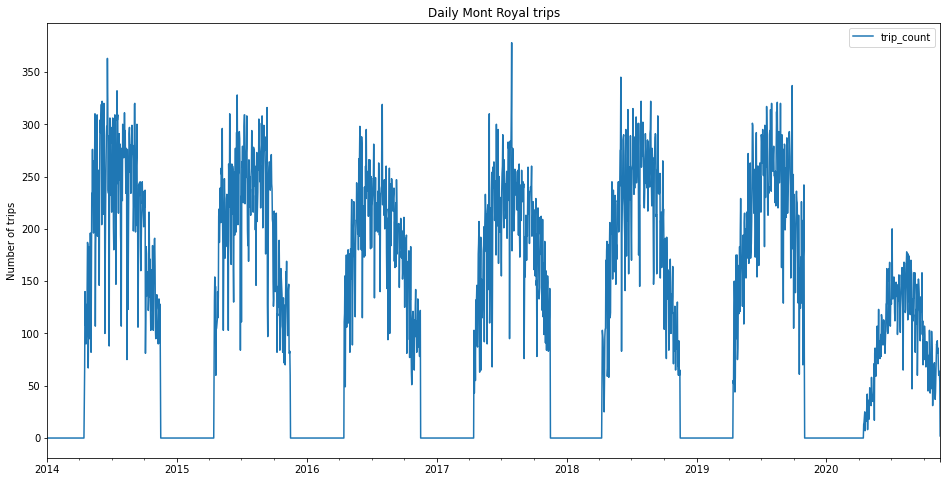

In [3]:
# Daily plot
mr_bike_demand.plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Daily Mont Royal trips')
plt.show()

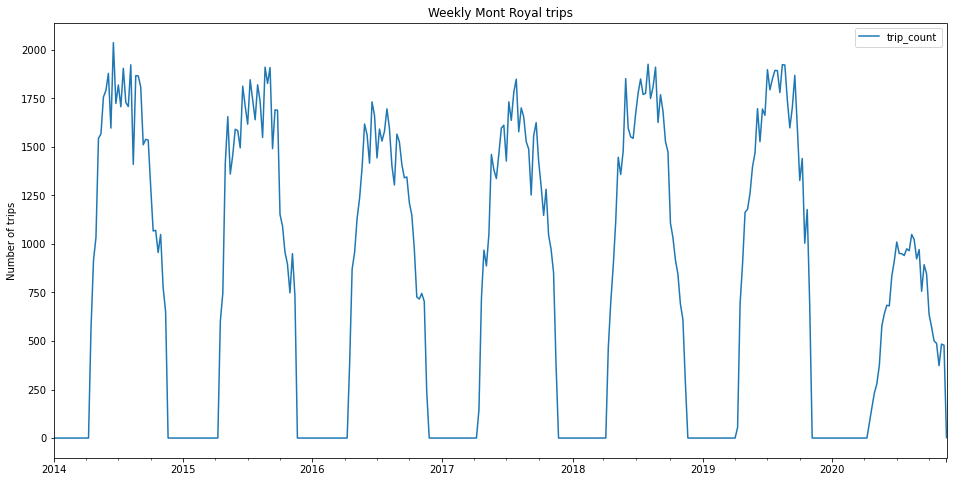

In [4]:
# Weekly plot
mr_bike_demand.resample('W').sum().plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Weekly Mont Royal trips')
plt.show()

As we can see, there is a very clear yearly periodicity on the data.

Let's zoom in on a particular year/month and examine shorter term history.

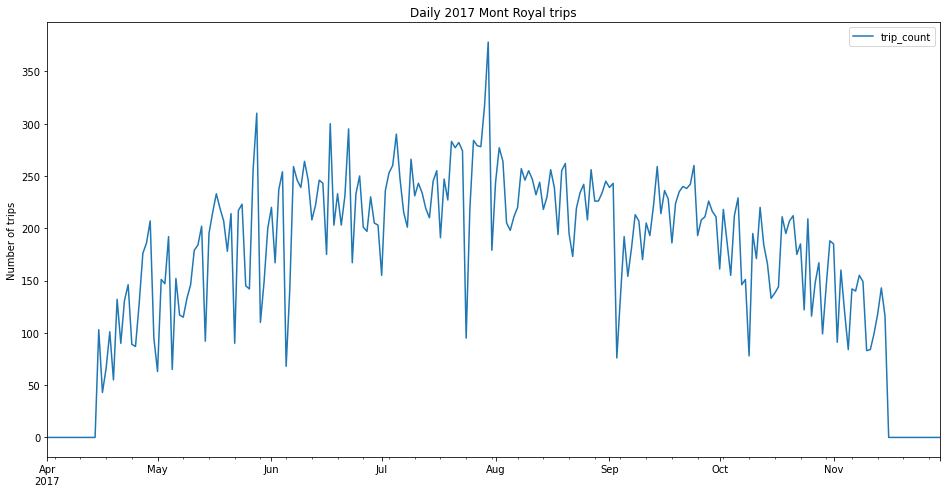

In [5]:
# Daily plot for 2017
mr_bike_demand.loc['2017-04':'2017-11'].plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Daily 2017 Mont Royal trips')
plt.show()

There is a clear pattern within each year, with the demand steadily increasing until the peak in late July/early August and then decreasing.

Let's look at the data for one month and the weekday data.

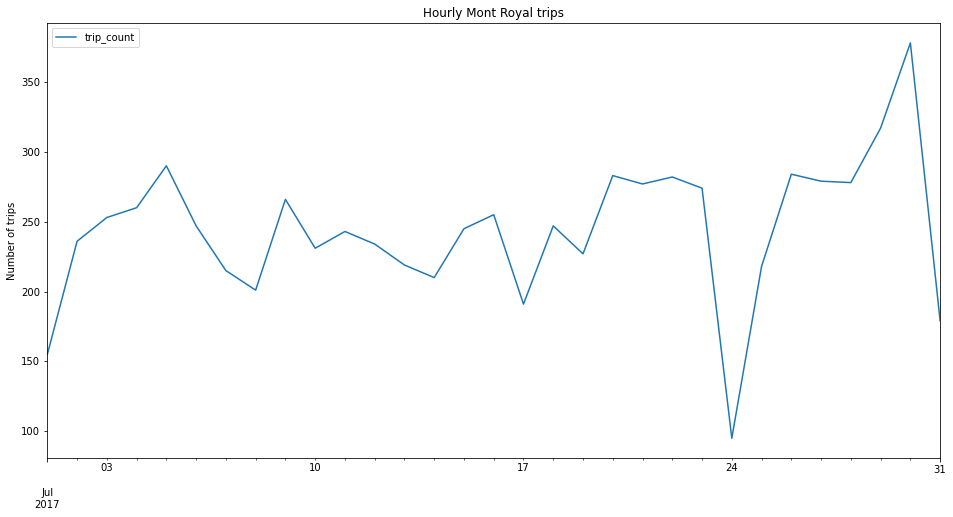

In [6]:
# Daily plot for July 2017
mr_bike_demand.loc['2017-07'].plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Hourly Mont Royal trips')
plt.show()

From the graph above, it doesn't look like there is an immediately apparent pattern within the chosen month.

Let's look at the trip count with respect to days of the week for the whole data set.

<AxesSubplot:xlabel='weekday'>

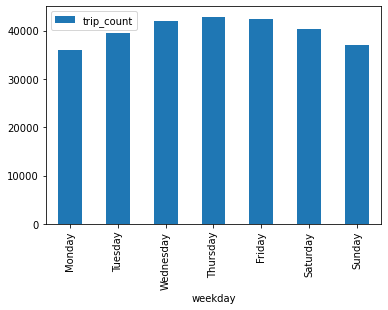

In [7]:
# Copy demand data
weekday_demand = mr_bike_demand.copy()

# Add weekdays to each sample
weekday_demand['weekday_index'] = weekday_demand.index.dayofweek
weekday_demand = weekday_demand.groupby('weekday_index').sum()

# Create labels for each weekday
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
weekday_demand['weekday'] = weekday_demand.index.map(dayOfWeek)

# Draw a bar plot
weekday_demand.plot.bar(x='weekday', y='trip_count')

As we can see, there is a slight overall weekly trend in the data with bike usage being at its peek in the middle of the week.

## Seasonal Decomposition

Decompose the data into trend, periodic and noise components.

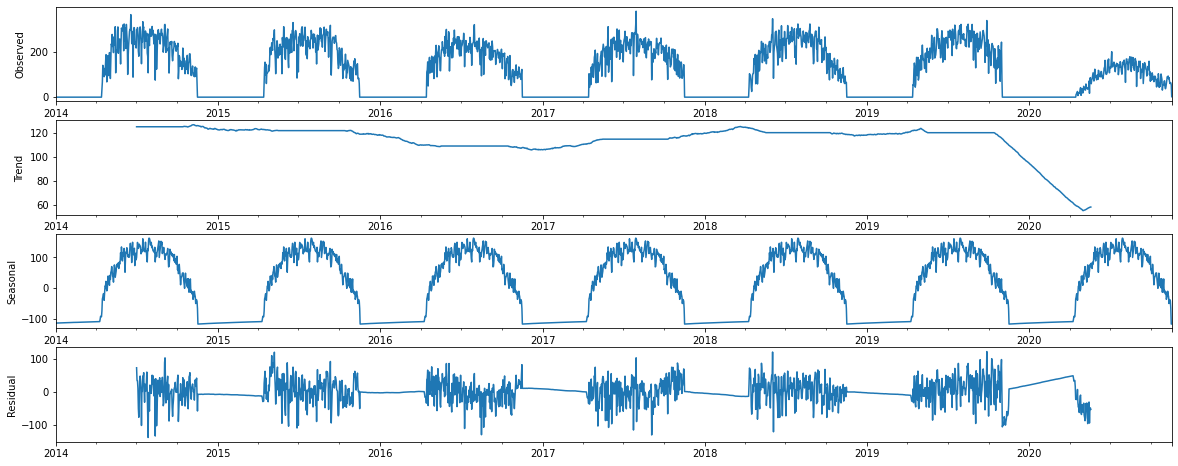

In [8]:
# Configure the period to be annual
period = 365

# Decompose the data
decomposed_trip_data = sm.tsa.seasonal_decompose(mr_bike_demand["trip_count"], period=period)

# Plot each decompostition component
ig, axes = plt.subplots(4, 1, figsize=(20,8))

decomposed_trip_data.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decomposed_trip_data.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decomposed_trip_data.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposed_trip_data.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual');

A few observations:
* The trend is relatively constant throughout the years with a large dip at the end of 2019 (missing November data) and into 2020 (pandemic)
* There a strong overall yearly periodic component
* There is still a significant amount of noise among individual samples

## Autocorrelation

Let's see what the autocorrelation looks like with up to 2 year lag.

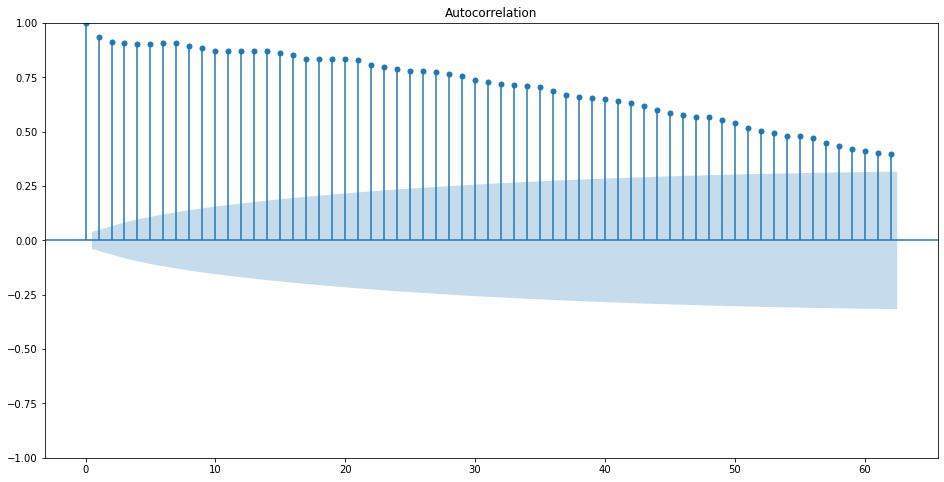

In [9]:
# Autocorrelation with up to two months lag
plt.rc("figure", figsize=(16,8))
plot_acf(mr_bike_demand["trip_count"], lags=2*31)
plt.show()

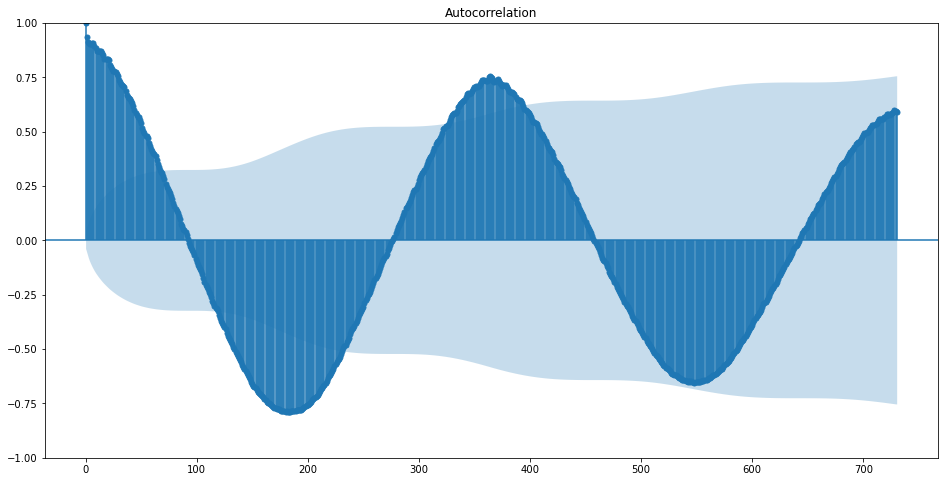

In [10]:
# Autocorrelation with up to two years lag
plt.rc("figure", figsize=(16,8))
plot_acf(mr_bike_demand["trip_count"], lags=2*period)
plt.show()

As we can see, there is a statistically significant autocorrelation at each level:
* Previous day/week/month usage is generally correlated with the next
* Previous year usage is generally correlated with the next

# Weather Data

Let's explore the weather data and see if there is a correlation with the bike demand.

In [11]:
# Load the weather data
weather_df = pd.read_csv('data/weather.csv', index_col='Date/Time', parse_dates=['Date/Time'])

# Concatednate weather data with bike demand time-series
demand_weather_df = pd.concat([mr_bike_demand ,weather_df], axis=1)[:'2019']
display(demand_weather_df)

,trip_count,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Precip (mm),Spd of Max Gust (km/h)
2014-01-01,0,-15.2,-23.9,-19.6,0.0,31.0
2014-01-02,0,-22.3,-27.4,-24.9,0.0,37.0
2014-01-03,0,-19.0,-23.6,-21.3,1.0,31.0
2014-01-04,0,-6.6,-21.3,-14.0,0.0,31.0
2014-01-05,0,0.2,-10.6,-5.2,8.0,31.0
...,...,...,...,...,...,...
2019-12-27,0,3.5,-4.8,-0.6,7.2,41.0
2019-12-28,0,4.2,-0.2,2.0,0.2,46.0
2019-12-29,0,0.8,-2.9,-1.1,0.0,31.0
2019-12-30,0,-1.3,-4.1,-2.7,16.0,36.0


Let's normalize the weather data to better see the distributions of each feature.

<AxesSubplot:>

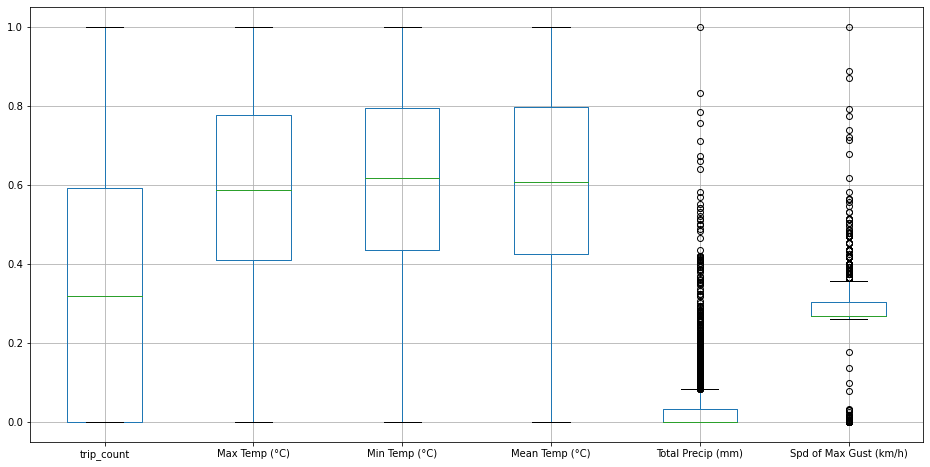

In [12]:
# Define a min-max scaller
min_max_scaler = sklearn.preprocessing.MinMaxScaler()

# Scale the data as a numpy array and convert back to a dataframe
data_scaled = min_max_scaler.fit_transform(demand_weather_df.values)
demand_weather_scaled = pd.DataFrame(data_scaled, columns=demand_weather_df.columns, index=demand_weather_df.index)

# Draw a boxplot showing the distribution of each feature
demand_weather_scaled.boxplot()

The total precipitation as well as wind speed have quite a few outliers, corresponding to abnormally high amount of precipitation and large wind speeds. We expect these to have a noticeable effect of the daily bike usage.

In [13]:
# Print a table demonstrating the correlation between trip count and weather for entries we have demand data for
print("Correlation table:")
demand_weather_scaled.loc[demand_weather_scaled['trip_count'] != 0].corr()

Correlation table:


,trip_count,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Precip (mm),Spd of Max Gust (km/h)
trip_count,1.000000,0.742134,0.678820,0.725564,-0.388180,-0.051443
Max Temp (°C),0.742134,1.000000,0.925225,0.983651,-0.097238,0.034217
Min Temp (°C),0.678820,0.925225,1.000000,0.977937,-0.003870,0.026483
Mean Temp (°C),0.725564,0.983651,0.977937,1.000000,-0.054154,0.031211
Total Precip (mm),-0.388180,-0.097238,-0.003870,-0.054154,1.000000,0.166908
Spd of Max Gust (km/h),-0.051443,0.034217,0.026483,0.031211,0.166908,1.000000


As we can see, there is a notable positive correlation between trip count and temperature, as well as a negative correlation between trip count and precipitation.